# Import Packages and Helper Functions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import random, os, pathlib, itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Flatten, Conv2D, InputLayer, Input, BatchNormalization
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import EfficientNetB7, efficientnet_v2, mobilenet_v3
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from google.colab import files
from glob import glob
import datetime

## Mounting Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Check GPU

In [ ]:

# if the GPU is not Tesla T4, Disconnect and rerun the runtime to get the GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-12c932fa-f3fb-f3dd-5da8-2bb6323fd2d4)


In [ ]:
# Define the train and test dir
train_path = "G:/My Drive/Paddy Dataset/train_images"
test_path = "G:/My Drive/Paddy Dataset/test_images"
images_path = glob(train_path + "/*/*.jp*g")

# EDA

In [6]:
# define the classname
data_dir = pathlib.Path(train_path)
classname = np.array(sorted([item.name for item in data_dir.glob("*")]))
classname

array(['Bercak Coklat pada Padi', 'Blas', 'Bulai Padi', 'Gores Daun',
       'Hawar Daun Padi', 'Hawar Malai Padi', 'Hispa', 'Kekeringan',
       'Normal', 'Tungro'], dtype='<U23')

In [7]:
def view_random_image(target_dir, target_class = False):
    # Set up the target directories
    if(target_class == False):
      target_forder = target_dir
    else:
      target_forder = target_dir + target_class

    # get a random image path
    random_image = random.sample(os.listdir(target_forder), 1)

    # Read in image and plot it using matplotlib
    img = mpimg.imread(target_forder + '/' + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off');

    print(f"image shape: {img.shape}\n image dtypes: {img.dtype}")

image shape: (640, 480, 3)
 image dtypes: uint8


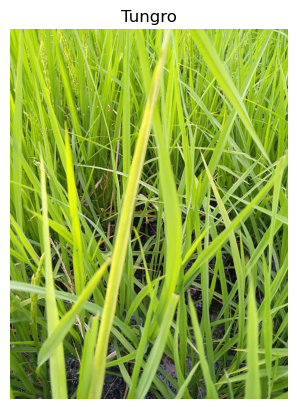

In [11]:
view_random_image("G:/My Drive/Paddy Dataset/train_images/", random.choice(classname))

image shape: (640, 480, 3)
 image dtypes: uint8


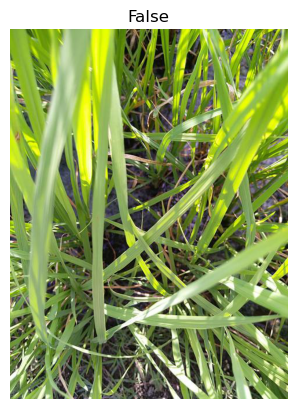

In [12]:
view_random_image("G:/My Drive/Paddy Dataset/test_images/")

# Get Dataset From Directory

In [5]:
train_data = image_dataset_from_directory(train_path,
                                          image_size=(224, 224),
                                          validation_split=0.2,
                                          subset = "training",
                                          label_mode = "categorical",
                                          seed = 42,
                                          shuffle=True)
val_data = image_dataset_from_directory(train_path,
                                        image_size=(224, 224),
                                        validation_split=0.2,
                                        subset="validation",
                                        label_mode = "categorical",
                                        seed = 42,
                                        shuffle=True)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


# Create Callbacks

In [6]:
checkpoint_path = "../Checkpoint/paddy/mobilenetv3-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".ckpt"
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   monitor = "val_accuracy",
                                   save_best_only = True,
                                   save_weight_only = True,
                                   verbose = 0)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', mode = 'max', factor = 0.2, patience = 2, min_lr=1e-5)

# Setup Mixed Precission Training

In [ ]:
mixed_precision.set_global_policy("mixed_float16")
mixed_precision.global_policy()

<Policy "mixed_float16">

# Modelling

## MobileNetV3 Functional Achitecture

In [8]:
base_model = tf.keras.applications.MobileNetV3Small(include_top = False,
                                             weights = 'imagenet',
                                             minimalistic=True)
mobilenet_preprocessor = tf.keras.applications.mobilenet_v3.preprocess_input
base_model.trainable = True
# freeze 10 layer below
for layer in base_model.layers[:-10]:
  layer.trainable = False
inputs = Input(shape = (224, 224, 3), dtype="float32")
x = mobilenet_preprocessor(inputs)
x = base_model(inputs)
x = Flatten()(x)
outputs = Dense(10, activation = "softmax", dtype="float32")(x)
MobileNetV2 = tf.keras.Model(inputs, outputs)
MobileNetV2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, None, None, 576)  441000    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 10)                282250    
                                                                 
Total params: 723,250
Trainable params: 400,522
Non-trainable params: 322,728
_________________________________________________________________


In [9]:
for layer in MobileNetV2.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
MobilenetV3small True float32 <Policy "float32">
flatten True float32 <Policy "float32">
dense True float32 <Policy "float32">


In [10]:
MobileNetV2.compile(optimizer = tf.keras.optimizers.Adam(),
                    loss = "categorical_crossentropy",
                    metrics = ['accuracy'])

In [11]:
checkpoint_path = "../Checkpoint/paddy/mobilenetv3-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".ckpt"
MobileNetV2.compile(optimizer = tf.keras.optimizers.Adam(),
                    loss = "categorical_crossentropy",
                    metrics = ['accuracy'])
MobileNetV2.fit(train_data,
        epochs = 100,
        steps_per_epoch = len(train_data),
        validation_data = val_data,
        validation_steps = len(val_data),
        callbacks = [early_stopping, reduce_lr])
MobileNetV2.save_weights(checkpoint_path)

Epoch 1/100


261/261 [==============================] - 47s 157ms/step - loss: 1.1840 - accuracy: 0.7235 - val_loss: 2.0822 - val_accuracy: 0.5425 - lr: 0.0010
Epoch 2/100
261/261 [==============================] - 43s 160ms/step - loss: 0.0611 - accuracy: 0.9810 - val_loss: 1.1339 - val_accuracy: 0.7165 - lr: 0.0010
Epoch 3/100
261/261 [==============================] - 42s 156ms/step - loss: 0.0177 - accuracy: 0.9971 - val_loss: 0.8118 - val_accuracy: 0.7967 - lr: 0.0010
Epoch 4/100
261/261 [==============================] - 43s 162ms/step - loss: 0.0143 - accuracy: 0.9987 - val_loss: 0.6303 - val_accuracy: 0.8424 - lr: 0.0010
Epoch 5/100
261/261 [==============================] - 42s 156ms/step - loss: 0.0071 - accuracy: 0.9989 - val_loss: 0.5517 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 6/100
261/261 [==============================] - 43s 160ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.4518 - val_accuracy: 0.8919 - lr: 0.0010
Epoch 7/100
261/261 [==============================] - 42s

In [ ]:
checkpoint_path = "../Checkpoint/paddy/mobilenetv3-" + + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".ckpt"
MobileNetV2.evaluate(val_data)

RuntimeError: ignored

## Load Checkpoint

In [ ]:
MobileNetV2.load_weights(checkpoint_path)
MobileNetV2.evaluate(val_data)

## Convert Model into TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(MobileNetV2)
tflite_model = converter.convert()

In [ ]:
open("../TFlite/paddy/penyakit_functional_architecture.tflite", "wb").write(tflite_model)

In [ ]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

convert_bytes(get_file_size("../TFlite/paddy/penyakit_functional_architecture.tflite"), "MB")

# Post Modelling EDA

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [ ]:
y_pred = np.array([])
y_val =  np.array([])
for x, y in val_data:
  y_pred = np.concatenate([y_pred, np.argmax(MobileNetV2.predict(x), axis = -1)])
  y_val = np.concatenate([y_val, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 0s 467ms/step


## Confusion Matrix

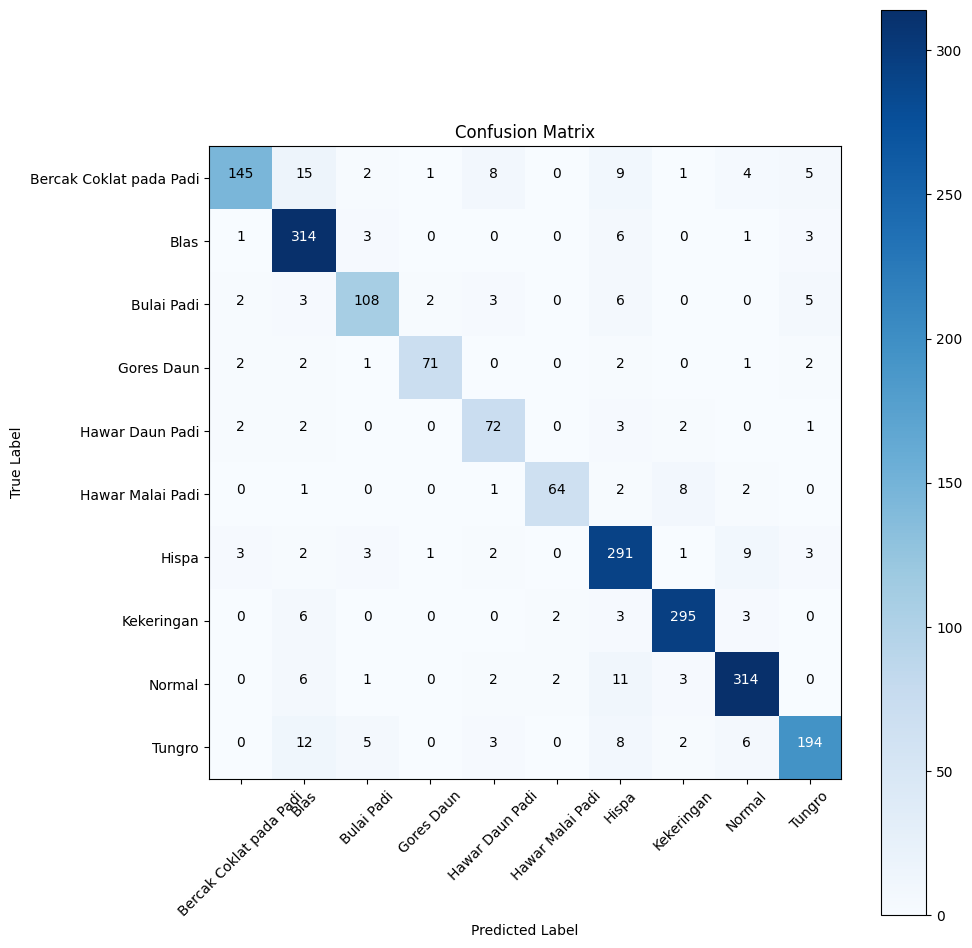

In [ ]:
cm = tf.math.confusion_matrix(labels=y_val, predictions=y_pred).numpy()
plot_confusion_matrix(cm= cm, classes= classname, title = 'Confusion Matrix')

## Classification Report

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84       190
         1.0       0.87      0.96      0.91       328
         2.0       0.88      0.84      0.86       129
         3.0       0.95      0.88      0.91        81
         4.0       0.79      0.88      0.83        82
         5.0       0.94      0.82      0.88        78
         6.0       0.85      0.92      0.89       315
         7.0       0.95      0.95      0.95       309
         8.0       0.92      0.93      0.92       339
         9.0       0.91      0.84      0.88       230

    accuracy                           0.90      2081
   macro avg       0.90      0.88      0.89      2081
weighted avg       0.90      0.90      0.90      2081



## Try to Predict Using Our Model

Saving WhatsApp Image 2023-07-27 at 14.01.16.jpeg to WhatsApp Image 2023-07-27 at 14.01.16 (1).jpeg
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-285a7a9a1f41>:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.title(classname[tf.argmax(classes, axis = 1)]);


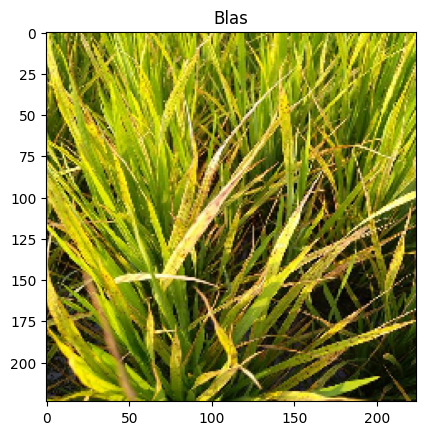

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  images = image.load_img(fn, target_size=(224, 224))
  x = image.img_to_array(images)
  x = np.expand_dims(x, axis = 0)
  img = np.vstack([x])
  classes = MobileNetV2.predict(img)
  implot = plt.imshow(images)
  plt.title(classname[tf.argmax(classes, axis = 1)]);